# **Tiền xử lý dữ liệu**

Làm dữ liệu sạch sẽ hơn

Ở đây ta sẽ tập trung chủ yếu phân tích từ bình luận của người dùng như thế nào, phân tích cảm xúc cũng như tiền xử lý cho giai đoạn build model


In [22]:
import os
import sys
current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)
if project_root not in sys.path:
    sys.path.append(project_root)

from src.data_processing import *
from src.config import *

In [23]:
data = np.load(FILE_PATH_PROCESSED_MISSING_SENTIMENT, allow_pickle=True)
print(data)

[(1340539111971516416, 'Rachel Roh', 'usa', '"Aggregator of Asian American news; scanning diverse sources 24/7/365. RT\'s; Follows and \'Likes\' will fuel me 👩\u200d💻"', '2009-04-08T17:52:46',    405, 1692, 3247, False, '2020-12-20T06:06:44', 'Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF', 'pfizerbiontech', 'Twitter for Android', 0, 0, False, 'norm', 0., 0.00000000e+00, 2.39220319e-01, 369231238,  97, 1, 0)
 (1338158543359250433, 'Albert Fong', 'usa', '"Marketing dude; tech geek; heavy metal & \'80s music junkie. Fascinated by meteorology and all things in the cloud. Opinions are my own."', '2009-09-21T15:27:30',    834,  666,  178, False, '2020-12-13T16:27:13', '"While the world has been on the wrong side of history this year; hopefully; the biggest vaccination effort we\'ve ev… https://t.co/dlCHrZjkhm"', 'no_hashtag', 'Twitter Web App', 1, 1, False, 'norm', 2., 2.39808153e-03, 1.25037481e+00, 354329983, 142, 0, 0)
 (133785819914011

In [24]:
print("Các kiểu dữ liệu của các cột")
data.dtype.descr

Các kiểu dữ liệu của các cột


[('id', '<i8'),
 ('user_name', '<U52'),
 ('user_location', '<U120'),
 ('user_description', '<U229'),
 ('user_created', '<M8[s]'),
 ('user_followers', '<i8'),
 ('user_friends', '<i8'),
 ('user_favourites', '<i8'),
 ('user_verified', '|b1'),
 ('date', '<M8[s]'),
 ('text', '<U156'),
 ('hashtags', '<U140'),
 ('source', '<U31'),
 ('retweets', '<i8'),
 ('favorites', '<i8'),
 ('is_retweet', '|b1'),
 ('acc_class', '<U15'),
 ('engagement', '<f8'),
 ('engagement_rate', '<f8'),
 ('reputation_ratio', '<f8'),
 ('acc_age', '<m8[s]'),
 ('tweet_lengths', '<i8'),
 ('hashtags_count', '<i8'),
 ('mentions_count', '<i8')]

In [25]:
new_data = data.copy() # tránh mất dữ liệu gốc

---

### **Xử lý nội dung các tweet (NLP)**

In [26]:
print("Đang xử lý văn bản và tính toán nhãn cảm xúc...")

cleaned_texts = []    # Để lưu text sạch (cho file .npz)
sentiment_labels = [] # Để lưu nhãn (cho cả new_data và .npz)

for t in new_data['text']:
    # Xử lý byte string nếu cần
    if isinstance(t, bytes): 
        t_str = t.decode('utf-8')
    else:
        t_str = str(t)
    
    # Làm sạch 
    cleaned_t = clean_text(t_str) 
    cleaned_texts.append(cleaned_t)
    
    # Gán nhãn
    label = generate_sentiment_label(cleaned_t)
    sentiment_labels.append(label)

# Chuyển sang numpy array
cleaned_texts = np.array(cleaned_texts)
sentiment_labels = np.array(sentiment_labels)

print(f"Đã xử lý xong {len(sentiment_labels)} dòng.")

# lưu trường mới
if 'sentiment_label' not in new_data.dtype.names:
    new_data = rfn.append_fields(
        base=new_data, 
        names='sentiment_label', 
        data=sentiment_labels, 
        usemask=False
    )
    print("-> Đã thêm cột 'sentiment_label' vào new_data.")
else:
    new_data['sentiment_label'] = sentiment_labels
    print("-> Đã cập nhật cột 'sentiment_label' trong new_data.")

# gán lại text đã xử lý
new_data['text'] = cleaned_texts

# LƯU FILE CHO MODELING
print(f"-> Đang lưu file '{FILE_PATH_SENTIMENT}' cho bước Modeling...")
np.savez(FILE_PATH_SENTIMENT, X_text=cleaned_texts, y=sentiment_labels)
print("Hoàn tất lưu file!")

Đang xử lý văn bản và tính toán nhãn cảm xúc...
Đã xử lý xong 11020 dòng.
-> Đã thêm cột 'sentiment_label' vào new_data.
-> Đang lưu file '../data/processed/sentiment_data.npz' cho bước Modeling...
Hoàn tất lưu file!


---
### **Phân tích cảm xúc**

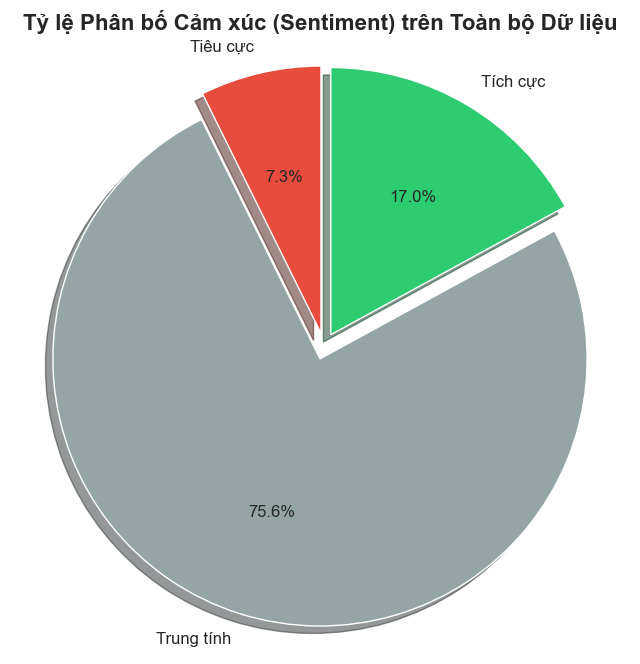

In [27]:

sentiments = new_data['sentiment_label']
unique, counts = np.unique(sentiments, return_counts=True)

# 2. Map nhãn và màu sắc
sent_map = {0: 'Tiêu cực', 1: 'Trung tính', 2: 'Tích cực'}
labels = [sent_map[u] for u in unique]
colors = ['#e74c3c', '#95a5a6', '#2ecc71'] # Đỏ, Xám, Xanh lá cây (tương ứng 0, 1, 2)

# Đảm bảo màu khớp với nhãn (nếu dữ liệu thiếu class nào đó)
colors_mapped = []
for u in unique:
    if u == 0: colors_mapped.append('#e74c3c')
    elif u == 1: colors_mapped.append('#95a5a6')
    elif u == 2: colors_mapped.append('#2ecc71')

# 3. Vẽ biểu đồ Pie
plt.figure(figsize=(8, 8))
plt.pie(counts, 
        labels=labels, 
        autopct='%1.1f%%', 
        startangle=90, 
        colors=colors_mapped, 
        explode=[0.05]*len(unique), # Tách nhẹ các miếng bánh ra
        shadow=True)

plt.title('Tỷ lệ Phân bố Cảm xúc (Sentiment) trên Toàn bộ Dữ liệu', fontsize=16, fontweight='bold')
plt.axis('equal') # Đảm bảo biểu đồ tròn vo
plt.show()

#### **Nhận xét**
- Phần lớn là các bài tweets mang tính **Trung tính** (dựa trên hàm đã lập trình thì vẫn chưa kiểm chứng được điều này, sẽ cập nhật sau), ta có thể suy luận như trước thì có thể các tin chính thống từ các bài báo hoặc các nhà đài đưa tin 
- Để phân tich sự ủng hộ của người dân thì ta cần phân tích trọng tâm hơn vào bài tweet nào mang **Tính cực**, bài viết nào mang tính **Tiêu cực** để hiểu rõ và sâu sắc hơn. 

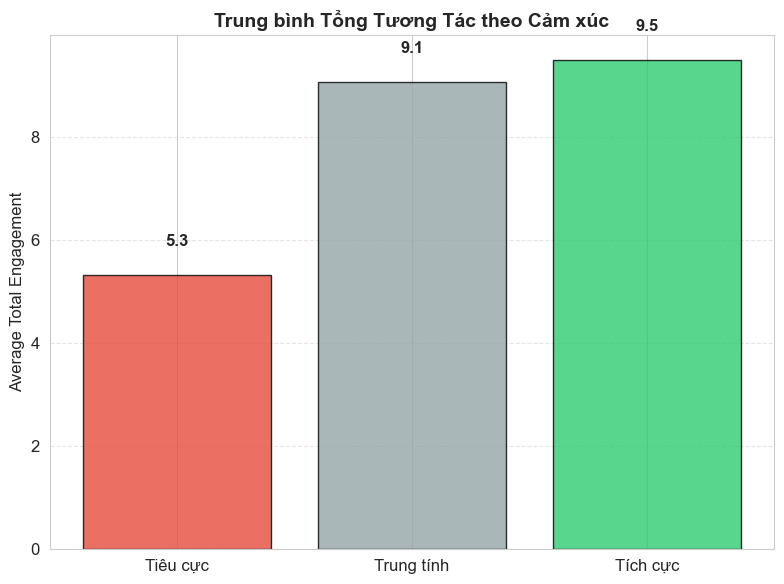

In [28]:
# 1. Lấy dữ liệu
sentiments = new_data['sentiment_label']
total_eng = new_data['engagement'].astype(float)

# Map nhãn
sent_map = {0: 'Tiêu cực', 1: 'Trung tính', 2: 'Tích cực'}
colors = ['#e74c3c', '#95a5a6', '#2ecc71'] # Đỏ, Xám, Xanh

# 2. Tính trung bình
avg_eng_by_sent = []
for s in [0, 1, 2]:
    mask = sentiments == s
    if np.sum(mask) > 0:
        avg = np.mean(total_eng[mask])
    else:
        avg = 0
    avg_eng_by_sent.append(avg)

# 3. Vẽ biểu đồ (Duy nhất 1 biểu đồ Bar Chart)
plt.figure(figsize=(8, 6))
ax = plt.gca()

bars = ax.bar([sent_map[0], sent_map[1], sent_map[2]], avg_eng_by_sent, 
              color=colors, alpha=0.8, edgecolor='black')

ax.set_title('Trung bình Tổng Tương Tác theo Cảm xúc', fontsize=14, fontweight='bold')
ax.set_ylabel('Average Total Engagement')
ax.grid(axis='y', linestyle='--', alpha=0.5)

# Hiển thị số trên cột
for bar, val in zip(bars, avg_eng_by_sent):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.5, 
            f'{val:.1f}', 
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

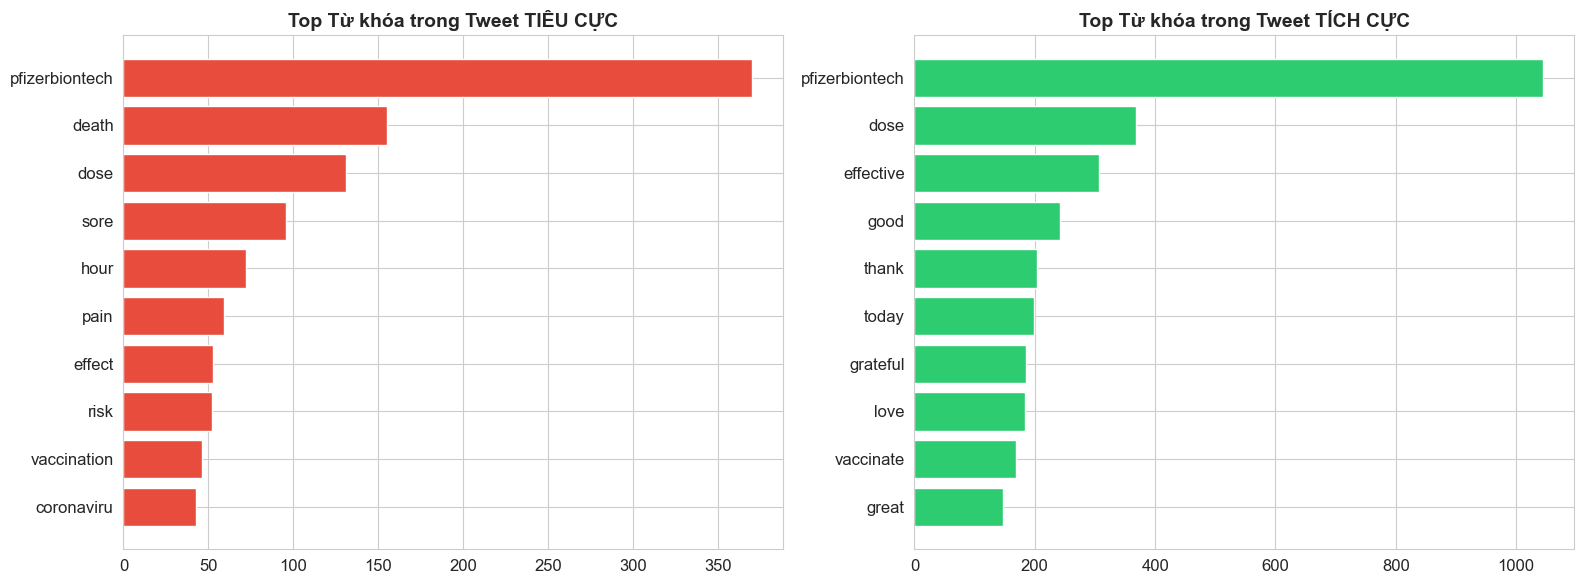

In [29]:


# PHÂN TÍCH TỪ KHÓA THEO CẢM XÚC (ĐƠN TỪ)


# Tách dữ liệu theo nhãn
neg_text = new_data['text'][new_data['sentiment_label'] == 0]
pos_text = new_data['text'][new_data['sentiment_label'] == 2]

neg_kws = get_keywords(neg_text, 10)
pos_kws = get_keywords(pos_text, 10)

# Vẽ biểu đồ so sánh từ khóa
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Biểu đồ Tiêu cực
words, counts = zip(*neg_kws)
axes[0].barh(words, counts, color='#e74c3c')
axes[0].invert_yaxis()
axes[0].set_title('Top Từ khóa trong Tweet TIÊU CỰC', fontsize=14, fontweight='bold')

# Biểu đồ Tích cực
words, counts = zip(*pos_kws)
axes[1].barh(words, counts, color='#2ecc71')
axes[1].invert_yaxis()
axes[1].set_title('Top Từ khóa trong Tweet TÍCH CỰC', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()





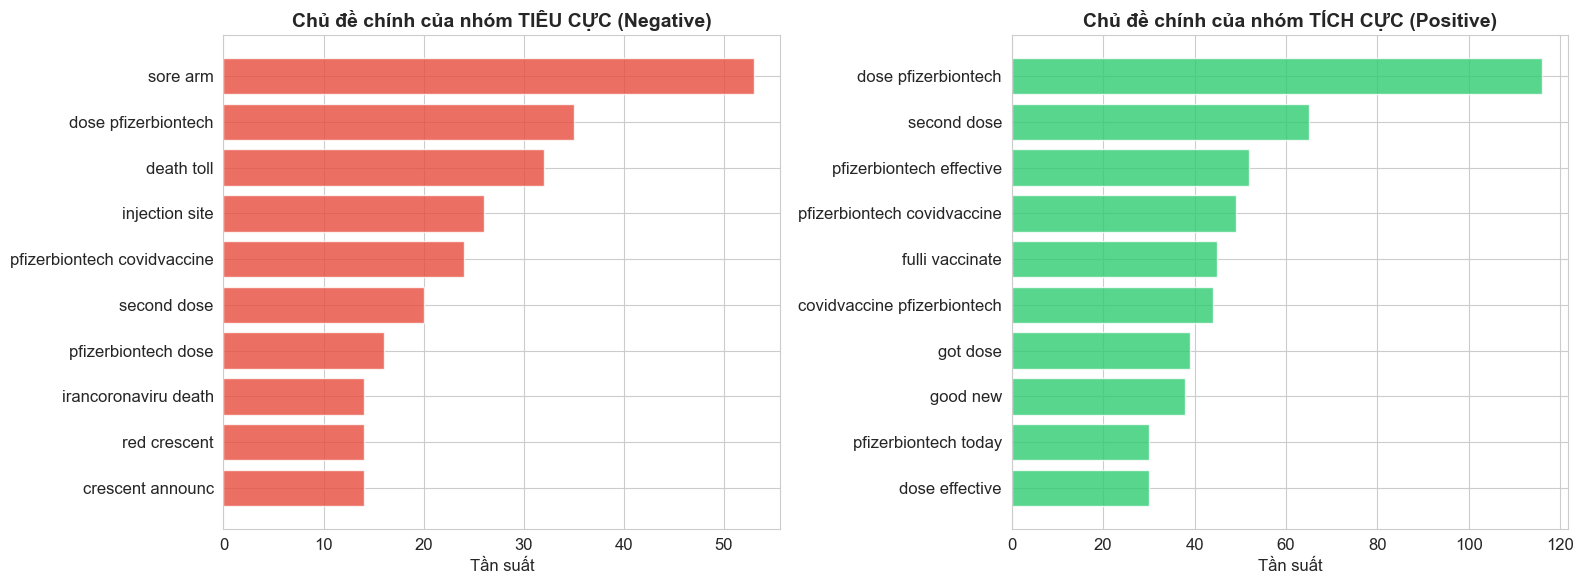

In [30]:

# PHÂN TÍCH TỪ KHÓA THEO CẢM XÚC (CẶP TỪ)



neg_texts = new_data['text'][new_data['sentiment_label'] == 0]
pos_texts = new_data['text'][new_data['sentiment_label'] == 2]

neg_bigrams = get_bigrams(neg_texts, 10)
pos_bigrams = get_bigrams(pos_texts, 10)

#biểu đồ đối sánh
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Biểu đồ Tiêu cực
words, counts = zip(*neg_bigrams)
axes[0].barh(words, counts, color='#e74c3c', alpha=0.8)
axes[0].invert_yaxis()
axes[0].set_title('Chủ đề chính của nhóm TIÊU CỰC (Negative)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Tần suất')

# Biểu đồ Tích cực
words, counts = zip(*pos_bigrams)
axes[1].barh(words, counts, color='#2ecc71', alpha=0.8)
axes[1].invert_yaxis()
axes[1].set_title('Chủ đề chính của nhóm TÍCH CỰC (Positive)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Tần suất')

plt.tight_layout()
plt.show()

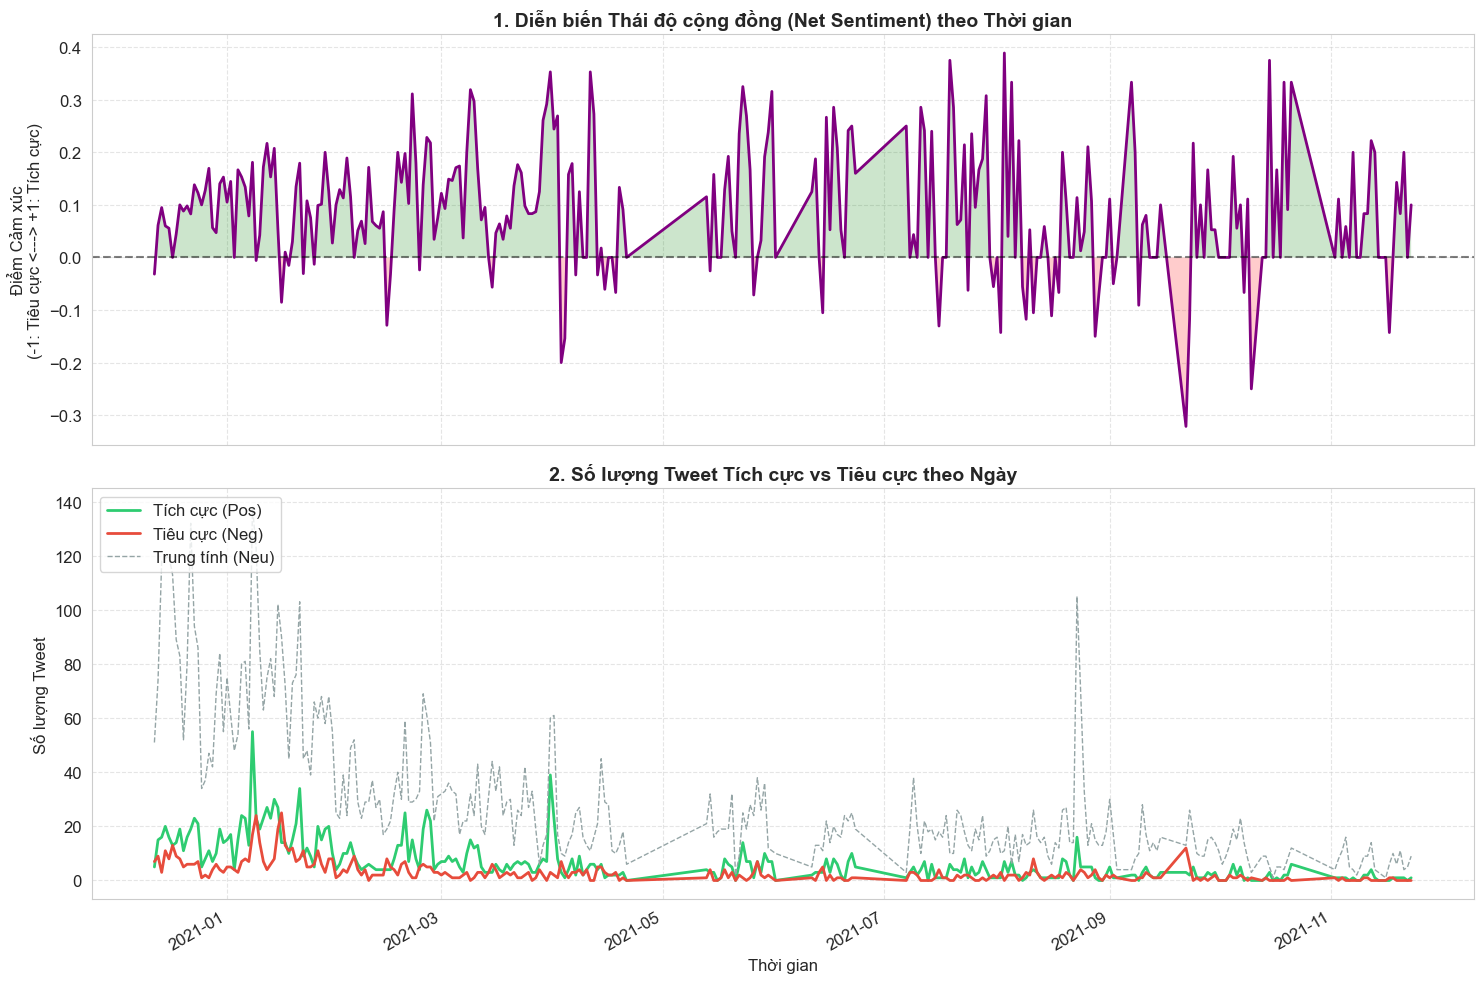

In [31]:
from collections import defaultdict

# --- 1. CHUẨN BỊ DỮ LIỆU ---
# Giả sử new_data đã có 'date' và 'sentiment_label'
if 'sentiment_label' not in new_data.dtype.names:
    print("LỖI: Bạn cần chạy bước gán nhãn cảm xúc (File 02) trước!")
else:
    dates = new_data['date'].astype('datetime64[D]') # Lấy ngày
    sentiments = new_data['sentiment_label']

    # --- 2. GOM NHÓM DỮ LIỆU THEO NGÀY (Aggregation) ---
    # Cấu trúc: { '2020-12-01': {'sum': 0, 'count': 0, 'pos': 0, 'neg': 0, 'neu': 0}, ... }
    daily_data = defaultdict(lambda: {'sum_score': 0, 'count': 0, 'neg': 0, 'neu': 0, 'pos': 0})

    for d, s in zip(dates, sentiments):
        d_str = str(d)
        
        # Tính điểm Net Sentiment: (Pos - Neg)
        # Quy ước: 0(Neg) -> -1, 1(Neu) -> 0, 2(Pos) -> +1
        score = s - 1
        
        daily_data[d_str]['sum_score'] += score
        daily_data[d_str]['count'] += 1
        
        # Đếm số lượng từng loại
        if s == 0: daily_data[d_str]['neg'] += 1
        elif s == 1: daily_data[d_str]['neu'] += 1
        elif s == 2: daily_data[d_str]['pos'] += 1

    # --- 3. CHUYỂN ĐỔI SANG MẢNG ĐỂ VẼ ---
    sorted_dates = sorted(daily_data.keys())
    dates_obj = np.array(sorted_dates, dtype='datetime64[D]') # Trục X

    net_sentiment = [] # Trục Y1 (Điểm trung bình)
    vol_neg = []       # Trục Y2 (Số lượng Neg)
    vol_pos = []       # Trục Y3 (Số lượng Pos)
    vol_neu = []       # Trục Y4 (Số lượng Neu)

    for d in sorted_dates:
        stats = daily_data[d]
        # Tính trung bình: Tổng điểm / Tổng số tweet
        avg = stats['sum_score'] / stats['count'] if stats['count'] > 0 else 0
        net_sentiment.append(avg)
        
        vol_neg.append(stats['neg'])
        vol_pos.append(stats['pos'])
        vol_neu.append(stats['neu'])

    # --- 4. VẼ BIỂU ĐỒ (2 Subplots) ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    
    # --- BIỂU ĐỒ 1: NET SENTIMENT SCORE (Sự lên xuống của thái độ) ---
    ax1.plot(dates_obj, net_sentiment, color='purple', linewidth=2, label='Net Sentiment Score')
    
    # Vẽ đường tham chiếu 0 (Trung lập)
    ax1.axhline(0, color='black', linestyle='--', alpha=0.5)
    
    # Tô màu: Xanh lá nếu > 0 (Vui), Đỏ nếu < 0 (Buồn)
    ax1.fill_between(dates_obj, 0, net_sentiment, where=(np.array(net_sentiment)>=0), 
                     facecolor='green', alpha=0.2, interpolate=True)
    ax1.fill_between(dates_obj, 0, net_sentiment, where=(np.array(net_sentiment)<0), 
                     facecolor='red', alpha=0.2, interpolate=True)
    
    ax1.set_title('1. Diễn biến Thái độ cộng đồng (Net Sentiment) theo Thời gian', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Điểm Cảm xúc\n(-1: Tiêu cực <---> +1: Tích cực)')
    ax1.grid(True, linestyle='--', alpha=0.5)
    
    # --- BIỂU ĐỒ 2: KHỐI LƯỢNG TỪNG LOẠI CẢM XÚC (Volume Trend) ---
    ax2.plot(dates_obj, vol_pos, color='#2ecc71', label='Tích cực (Pos)', linewidth=2)
    ax2.plot(dates_obj, vol_neg, color='#e74c3c', label='Tiêu cực (Neg)', linewidth=2)
    ax2.plot(dates_obj, vol_neu, color='#95a5a6', label='Trung tính (Neu)', linewidth=1, linestyle='--')
    
    ax2.set_title('2. Số lượng Tweet Tích cực vs Tiêu cực theo Ngày', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Số lượng Tweet')
    ax2.set_xlabel('Thời gian')
    ax2.legend(loc='upper left')
    ax2.grid(True, linestyle='--', alpha=0.5)
    
    # Định dạng ngày tháng cho đẹp
    plt.gcf().autofmt_xdate()
    
    plt.tight_layout()
    plt.show()

In [ ]:

# TÍNH TOÁN CÁC CHỈ SỐ TIÊU CỰC THEO NGÀY 
dates = new_data['date'].astype('datetime64[D]')
sentiments = new_data['sentiment_label']

daily_neg_analysis = defaultdict(lambda: {'sum_score': 0, 'total_count': 0, 'neg_count': 0})

for d, s in zip(dates, sentiments):
    d_str = str(d)
    
    # Quy đổi điểm: 0(Neg) -> -1, 1(Neu) -> 0, 2(Pos) -> +1
    score = s - 1
    
    daily_neg_analysis[d_str]['sum_score'] += score
    daily_neg_analysis[d_str]['total_count'] += 1
    
    if s == 0: # Nhãn Tiêu cực
        daily_neg_analysis[d_str]['neg_count'] += 1

# TẠO DANH SÁCH CUỐI CÙNG 
final_list = []
for date_str, stats in daily_neg_analysis.items():
    if stats['total_count'] > 0:
        final_list.append({
            'date': date_str,
            'avg_sentiment': stats['sum_score'] / stats['total_count'], # Mức độ tiêu cực
            'neg_volume': stats['neg_count'],                          # Số lượng tweet tiêu cực
            'total_volume': stats['total_count']
        })

# Tạo bảng
# Bảng 1
# Sắp xếp: Theo avg_sentiment tăng dần (âm nhất lên đầu)
sorted_by_intensity = sorted(final_list, key=lambda x: x['avg_sentiment'])
top_10_intensity = sorted_by_intensity[:10]

print(f"\n{'='*10} BẢNG 1: TOP 10 NGÀY CÓ CẢM XÚC TIÊU CỰC SÂU SẮC NHẤT {'='*10}")
print(f"{'Hạng':<5} | {'Ngày':<12} | {'Net Sentiment (Avg)':<20} | {'Số Tweet Tiêu Cực':<15}")
print("-" * 60)

for rank, item in enumerate(top_10_intensity):
    print(f"#{rank+1:<4} | {item['date']:<12} | {item['avg_sentiment']:<20.4f} | {item['neg_volume']:<15,}")

# Bảng 2
# Sắp xếp: Theo neg_volume giảm dần (số lượng cao nhất lên đầu)
sorted_by_volume = sorted(final_list, key=lambda x: x['neg_volume'], reverse=True)
top_10_volume = sorted_by_volume[:10]

print(f"\n{'='*10} BẢNG 2: TOP 10 NGÀY CÓ SỐ LƯỢNG TWEET TIÊU CỰC LỚN NHẤT {'='*10}")
print(f"{'Hạng':<5} | {'Ngày':<12} | {'Số Tweet Tiêu Cực':<18} | {'Total Volume':<15}")
print("-" * 60)

for rank, item in enumerate(top_10_volume):
    print(f"#{rank+1:<4} | {item['date']:<12} | {item['neg_volume']:<18,} | {item['total_volume']:<15,}")


========== BẢNG 1: TOP 10 NGÀY CÓ CẢM XÚC TIÊU CỰC SÂU SẮC NHẤT ==========
Hạng  | Ngày         | Net Sentiment (Avg)  | Số Tweet Tiêu Cực
------------------------------------------------------------
#1    | 2021-09-22   | -0.3214              | 12             
#2    | 2021-10-10   | -0.2500              | 1              
#3    | 2021-04-03   | -0.2000              | 7              
#4    | 2021-04-04   | -0.1538              | 3              
#5    | 2021-08-28   | -0.1500              | 4              
#6    | 2021-08-02   | -0.1429              | 3              
#7    | 2021-11-17   | -0.1429              | 1              
#8    | 2021-07-16   | -0.1304              | 4              
#9    | 2021-02-14   | -0.1290              | 8              
#10   | 2021-08-09   | -0.1176              | 3              

========== BẢNG 2: TOP 10 NGÀY CÓ SỐ LƯỢNG TWEET TIÊU CỰC LỚN NHẤT ==========
Hạng  | Ngày         | Số Tweet Tiêu Cực  | Total Volume   
----------------------------------------

In [ ]:

dates_col = new_data['date'].astype('datetime64[D]').astype(str)
sent_col = new_data['sentiment_label']
text_col = new_data['text']


print(f"\n{'='*10} CHỦ ĐỀ TIÊU CỰC TRONG CÁC NGÀY KHỦNG HOẢNG NIỀM TIN (INTENSITY) {'='*10}")

top_10_intensity = top_10_intensity[:5]

for item in top_10_intensity:
    date = item['date']
    
    # Lọc tweet: Đúng ngày VÀ Là tiêu cực (0)
    mask = (dates_col == date) & (sent_col == 0)
    neg_texts = text_col[mask]
    
    if len(neg_texts) > 0:
        bigrams = get_bigrams(neg_texts, top_k=5)
        bigram_str = ", ".join([f"{b[0]}" for b in bigrams]) # Chỉ lấy từ, bỏ số lượng cho gọn
        
        print(f"\n{date} | Net Sent: {item['avg_sentiment']:.2f} | {len(neg_texts)} bài tiêu cực")
        print(f"Các từ chủ đạo: {bigram_str}")


print(f"\n\n{'='*10} CHỦ ĐỀ TIÊU CỰC TRONG CÁC NGÀY CÓ LƯỢNG PHÀN NÀN CAO NHẤT (VOLUME) {'='*10}")

top_5_volume = top_10_volume[:5]

for item in top_10_volume:
    date = item['date']
    
    # Lọc tweet: Đúng ngày VÀ Là tiêu cực (0)
    mask = (dates_col == date) & (sent_col == 0)
    neg_texts = text_col[mask]
    
    if len(neg_texts) > 0:
        bigrams = get_bigrams(neg_texts, top_k=5)
        bigram_str = ", ".join([f"{b[0]}" for b in bigrams])
        
        print(f"\n{date} | Neg Volume: {item['neg_volume']} bài")
        print(f"Các từ chủ đạo: {bigram_str}")


========== CHỦ ĐỀ TIÊU CỰC TRONG CÁC NGÀY KHỦNG HOẢNG NIỀM TIN (INTENSITY) ==========

2021-09-22 | Net Sent: -0.32 | 12 bài tiêu cực
Các từ chủ đạo: forget did, did poor, poor ppl, ppl nigerianigerian, nigerianigerian victim

2021-10-10 | Net Sent: -0.25 | 1 bài tiêu cực
Các từ chủ đạo: moderna reach, reach poor, poor nation

2021-04-03 | Net Sent: -0.20 | 7 bài tiêu cực
Các từ chủ đạo: day hour, curiou effect, effect got, got pfizerbiontech, pfizerbiontech jab

2021-04-04 | Net Sent: -0.15 | 3 bài tiêu cực
Các từ chủ đạo: vaccinate pfizerbiontech, pfizerbiontech dose, dose day, day pain, pain near

2021-08-28 | Net Sent: -0.15 | 4 bài tiêu cực
Các từ chủ đạo: left arm, pfizerbiontech jab, jab effect, effect yearold, yearold high


========== CHỦ ĐỀ TIÊU CỰC TRONG CÁC NGÀY CÓ LƯỢNG PHÀN NÀN CAO NHẤT (VOLUME) ==========

2021-01-16 | Neg Volume: 25 bài
Các từ chủ đạo: elderli patient, funni funni, china slam, slam media, media silence

2021-01-09 | Neg Volume: 24 bài
Các từ chủ đạo: p

#### **Ta cùng điểm qua một vài sự kiện trên**
- 22/09/2021: "Nigeria phải đối mặt với những thách thức đáng kể do tác động của tình trạng mất an ninh ngày càng gia tăng và cuộc khủng hoảng lương thực và nhân đạo,....hơn 80 triệu người Nigeria đã sống trong cảnh nghèo đói cùng cực trước đại dịch COVID-19" - CHATHAM HOUSE
- 15/01/2021: "Na Uy cảnh báo rằng tiêm vaccine COVID‑19 (Pfizer/BioNTech) “có thể quá rủi ro” cho những người rất già và bệnh nặng / suy yếu" - Bloomberg

#### **Nhận xét**
- Các bài có xư hướng `Tiêu cực` thì sẽ liên quan tới tình hình chung hiện tại trên thế giới (số người mất do covid,..) hay mọi người đang lo ngại rằng vaccine ảnh hưởng đến người cao tuổi. Còn lại là các bài thể hiện cảm xúc sau khi tiêm vaccine 
- Lưu ý những nhận định trên mang tính chủ quan

Nhóm User       | Tiêu cực (%)    | Trung tính (%)  | Tích cực (%)   
----------------------------------------------------------------------
Verified        | 6.3             | 81.1            | 12.6           
Unverified      | 7.4             | 75.1            | 17.5           


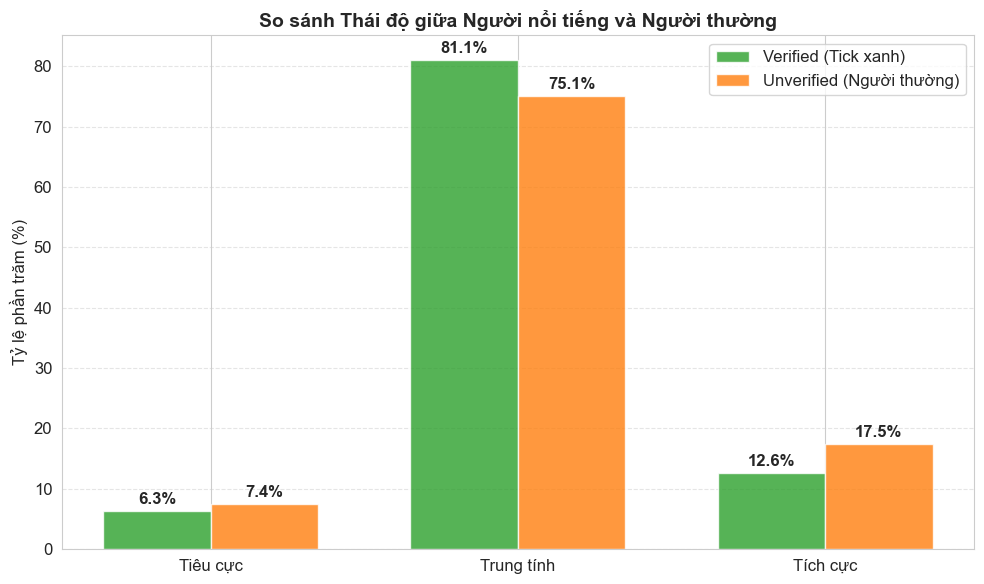

In [ ]:



sentiments = new_data['sentiment_label']
verified_status = new_data['user_verified'].astype(bool)


# Tách hai nhóm
ver_sentiments = sentiments[verified_status]
unver_sentiments = sentiments[~verified_status]

# 2. TÍNH TOÁN TỶ LỆ % 
# Hàm tính tỷ lệ phân bố cảm xúc
def get_sentiment_dist(arr_sent):
    total = len(arr_sent)
    if total == 0: return [0, 0, 0]
    
    # Đếm số lượng từng loại: 0 (Neg), 1 (Neu), 2 (Pos)
    count_neg = np.sum(arr_sent == 0)
    count_neu = np.sum(arr_sent == 1)
    count_pos = np.sum(arr_sent == 2)
    
    # Trả về tỷ lệ phần trăm
    return [count_neg/total * 100, count_neu/total * 100, count_pos/total * 100]

ver_dist = get_sentiment_dist(ver_sentiments)
unver_dist = get_sentiment_dist(unver_sentiments)

# In ra số liệu để báo cáo
print(f"{'Nhóm User':<15} | {'Tiêu cực (%)':<15} | {'Trung tính (%)':<15} | {'Tích cực (%)':<15}")
print("-" * 70)
print(f"{'Verified':<15} | {ver_dist[0]:<15.1f} | {ver_dist[1]:<15.1f} | {ver_dist[2]:<15.1f}")
print(f"{'Unverified':<15} | {unver_dist[0]:<15.1f} | {unver_dist[1]:<15.1f} | {unver_dist[2]:<15.1f}")

# TRỰC QUAN HÓA 
labels = ['Tiêu cực', 'Trung tính', 'Tích cực']
x = np.arange(len(labels))
width = 0.35  # Độ rộng cột

fig, ax = plt.subplots(figsize=(10, 6))

# Vẽ 2 nhóm cột cạnh nhau
rects1 = ax.bar(x - width/2, ver_dist, width, label='Verified (Tick xanh)', color='#2ca02c', alpha=0.8)
rects2 = ax.bar(x + width/2, unver_dist, width, label='Unverified (Người thường)', color='#ff7f0e', alpha=0.8)

# Trang trí
ax.set_ylabel('Tỷ lệ phần trăm (%)')
ax.set_title('So sánh Thái độ giữa Người có tầm ảnh hưởng và Người thường', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.5)

# Hiển thị số trên cột
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontweight='bold')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

#### **Nhận xét**
- Đối với nhóm `Verify`: Nội dung họ đăng tải chủ yếu mang tính thông báo, cung cấp thông tin, số liệu, ... ta có thể thấy ở cột trung tính mang chỉ số rất cao
- Đối với nhóm `Non Verify`: Bày tỏ cảm xúc họ chia sẻ trải nghiệm và cảm xúc, và ta có thể thấy có phần (17,5% thể hiện điều tích cực đến với loại vaccine mới này)

Nhóm User            | Tiêu cực   | Trung tính | Tích cực  
------------------------------------------------------------
week                 | 0.0       % | 0.0       % | 0.0       %
norm                 | 7.7       % | 73.7      % | 18.6      %
strong               | 8.0       % | 76.6      % | 15.5      %
influencer           | 3.5       % | 83.7      % | 12.8      %


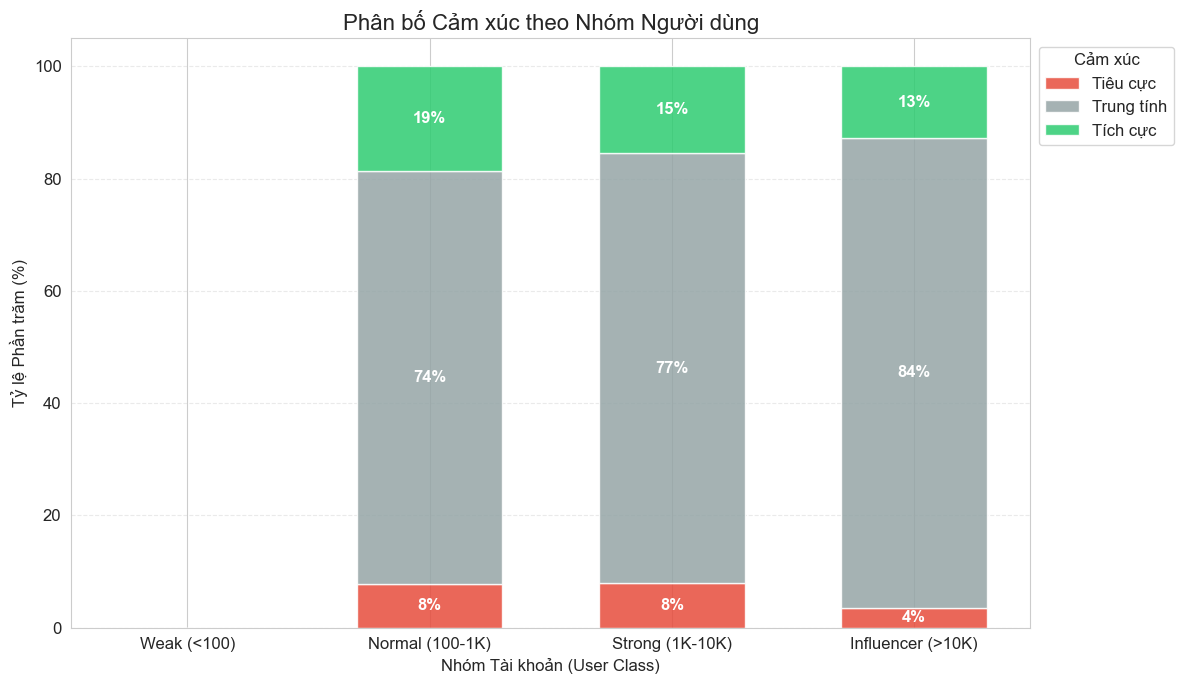

In [ ]:

# 1. Chuẩn bị dữ liệu
ordered_classes = ['week', 'norm', 'strong', 'influencer']
display_labels = ['Weak (<100)', 'Normal (100-1K)', 'Strong (1K-10K)', 'Influencer (>10K)']

classes = new_data['acc_class']
sentiments = new_data['sentiment_label']

# 2. Tính toán tỷ lệ %
class_sent_dist = []

print(f"{'Nhóm User':<20} | {'Tiêu cực':<10} | {'Trung tính':<10} | {'Tích cực':<10}")
print("-" * 60)

for cls in ordered_classes:
    mask = classes == cls
    total = np.sum(mask)
    
    if total > 0:
        sub_sent = sentiments[mask]
        n_neg = np.sum(sub_sent == 0)
        n_neu = np.sum(sub_sent == 1)
        n_pos = np.sum(sub_sent == 2)
        
        props = [n_neg/total*100, n_neu/total*100, n_pos/total*100]
    else:
        props = [0, 0, 0]
        
    class_sent_dist.append(props)
    print(f"{cls:<20} | {props[0]:<10.1f}% | {props[1]:<10.1f}% | {props[2]:<10.1f}%")

# 3. Trực quan hóa (Chỉ Stacked Bar Chart, không có đường Net Sentiment)
data_matrix = np.array(class_sent_dist).T 
neg_vals = data_matrix[0]
neu_vals = data_matrix[1]
pos_vals = data_matrix[2]

plt.figure(figsize=(12, 7))
bar_width = 0.6
x = np.arange(len(display_labels))

# Vẽ các thanh chồng lên nhau
p1 = plt.bar(x, neg_vals, bar_width, label='Tiêu cực', color='#e74c3c', alpha=0.85)
p2 = plt.bar(x, neu_vals, bar_width, bottom=neg_vals, label='Trung tính', color='#95a5a6', alpha=0.85)
p3 = plt.bar(x, pos_vals, bar_width, bottom=neg_vals+neu_vals, label='Tích cực', color='#2ecc71', alpha=0.85)

# Trang trí biểu đồ
plt.xlabel('Nhóm Tài khoản (User Class)', fontsize=12)
plt.ylabel('Tỷ lệ Phần trăm (%)', fontsize=12)
plt.title('Phân bố Cảm xúc theo Nhóm Người dùng', fontsize=16)
plt.xticks(x, display_labels)
plt.legend(loc='upper left', title='Cảm xúc', bbox_to_anchor=(1, 1)) # Đẩy legend ra ngoài cho đỡ vướng
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Hiển thị số % trên cột
for i in range(len(x)):
    # Tiêu cực
    if neg_vals[i] > 2: 
        plt.text(i, neg_vals[i]/2, f'{neg_vals[i]:.0f}%', ha='center', va='center', color='white', fontweight='bold')
    # Trung tính
    if neu_vals[i] > 2: 
        plt.text(i, neg_vals[i] + neu_vals[i]/2, f'{neu_vals[i]:.0f}%', ha='center', va='center', color='white', fontweight='bold')
    # Tích cực
    if pos_vals[i] > 2: 
        plt.text(i, neg_vals[i] + neu_vals[i] + pos_vals[i]/2, f'{pos_vals[i]:.0f}%', ha='center', va='center', color='white', fontweight='bold')

plt.tight_layout()
plt.show()

#### **Nhận xét**
- Ta thấy ở các nhóm số bài tích cực và trung tính chiếm ưu thế -> công chúng bày tỏ phần lớn là mang tính trung lập, một phần cảm thấy vui sướng và hưởng ứng.

#### **Và sau đây là các quan sát trên các trường dữ liệu khác, ta cũng có kết luận tương tự**

Cảnh báo: Chưa có 'source_category'. Đang dùng 'source' gốc (Top 5).


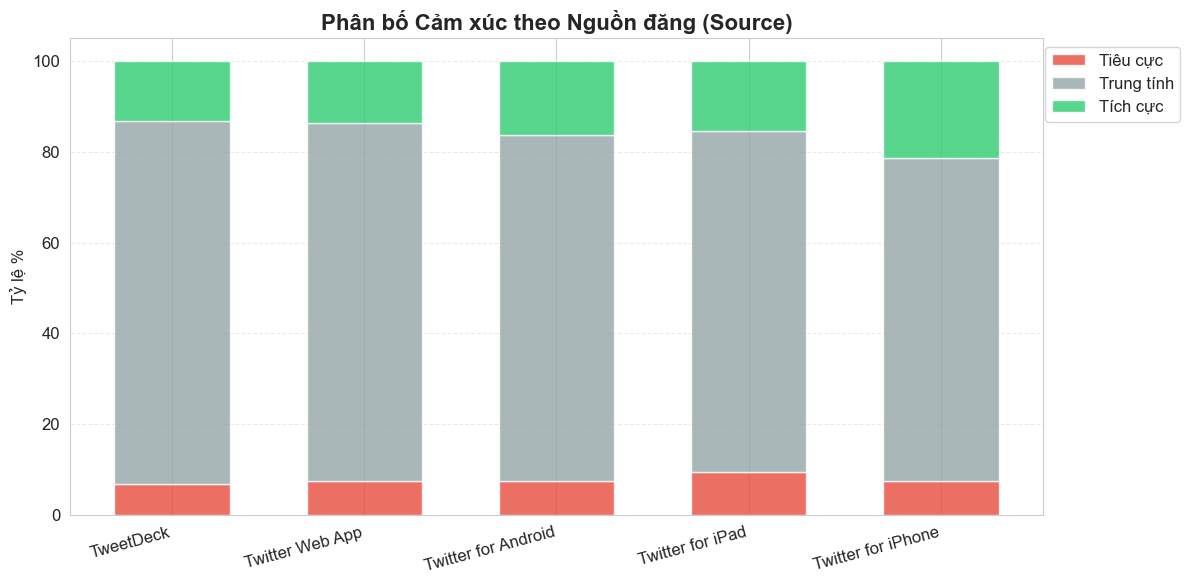

In [ ]:



# Giả sử bạn đã có cột 'source_category' (đã tạo ở bước trước)
# Nếu chưa, hãy dùng 'source' gốc (nhưng sẽ hơi rối)
if 'source_category' in new_data.dtype.names:
    sources = new_data['source_category']
else:
    print("Cảnh báo: Chưa có 'source_category'. Đang dùng 'source' gốc (Top 5).")
    # Lấy top 5 nguồn phổ biến nhất để phân tích
    top_src = [x[0] for x in Counter(new_data['source']).most_common(5)]
    # Chỉ lấy dữ liệu thuộc top 5 nguồn này
    mask = np.isin(new_data['source'], top_src)
    sources = new_data['source'][mask]
    # Cập nhật lại sentiment tương ứng với mask
    sentiments_subset = new_data['sentiment_label'][mask]

# Gom nhóm và tính tỷ lệ
unique_src = np.unique(sources)
src_sent_dist = {}

for src in unique_src:
    # Decode nếu là bytes
    src_label = src.decode('utf-8') if isinstance(src, bytes) else str(src)
    
    # Lọc sentiment theo nguồn
    if 'source_category' in new_data.dtype.names:
        mask = new_data['source_category'] == src
        sents = new_data['sentiment_label'][mask]
    else:
        mask = new_data['source'] == src
        sents = new_data['sentiment_label'][mask]
        
    total = len(sents)
    if total > 0:
        neg = np.sum(sents == 0) / total * 100
        neu = np.sum(sents == 1) / total * 100
        pos = np.sum(sents == 2) / total * 100
        src_sent_dist[src_label] = [neg, neu, pos]

# Vẽ Stacked Bar Chart
labels = list(src_sent_dist.keys())
neg_vals = [src_sent_dist[l][0] for l in labels]
neu_vals = [src_sent_dist[l][1] for l in labels]
pos_vals = [src_sent_dist[l][2] for l in labels]

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(labels))
width = 0.6

p1 = ax.bar(x, neg_vals, width, label='Tiêu cực', color='#e74c3c', alpha=0.8)
p2 = ax.bar(x, neu_vals, width, bottom=neg_vals, label='Trung tính', color='#95a5a6', alpha=0.8)
p3 = ax.bar(x, pos_vals, width, bottom=np.array(neg_vals)+np.array(neu_vals), label='Tích cực', color='#2ecc71', alpha=0.8)
ax.set_title('Phân bố Cảm xúc theo Nguồn đăng (Source)', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=15, ha='right')
ax.set_ylabel('Tỷ lệ %')
ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
ax.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

ℹ️ Đã xử lý xong. Hashtag phổ biến nhất xuất hiện 6067 lần.
-> Đang lọc các hashtag xuất hiện >= 20 lần...


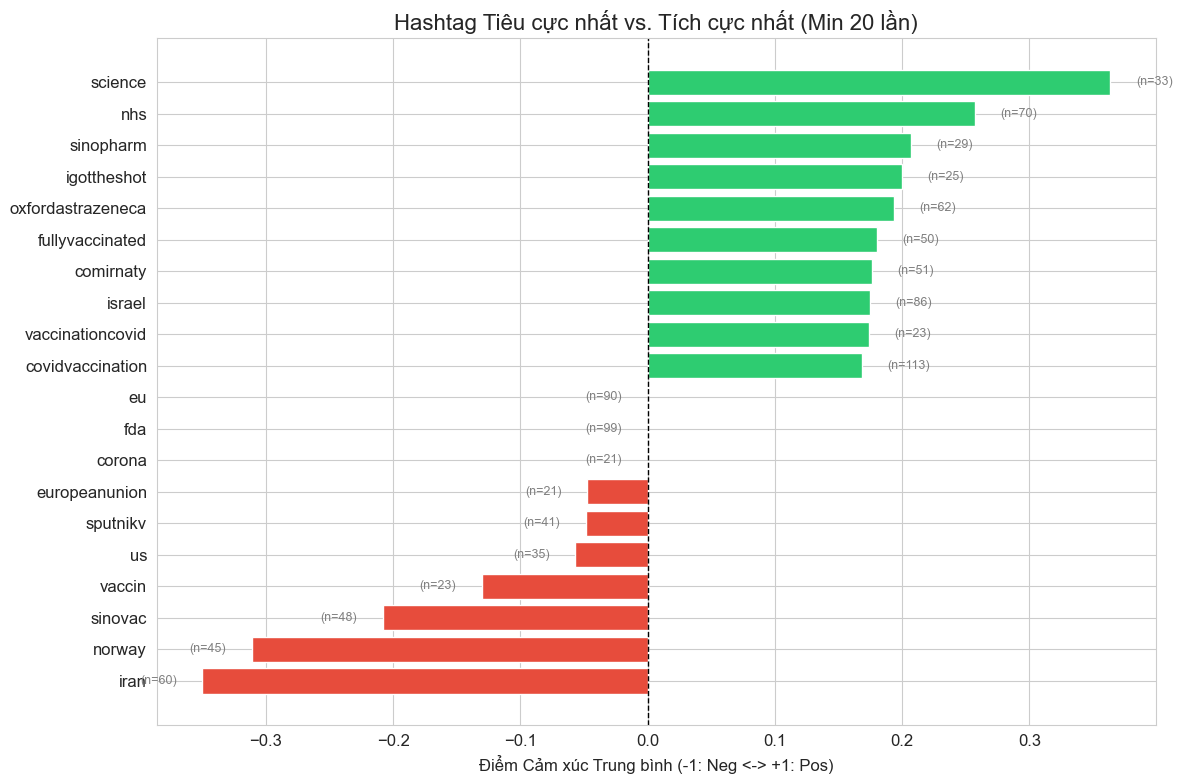

In [ ]:


# --- 1. Chuẩn bị dữ liệu ---
if 'hashtags' not in new_data.dtype.names or 'sentiment_label' not in new_data.dtype.names:
    print("LỖI: Thiếu cột 'hashtags' hoặc 'sentiment_label'.")
else:
    hashtags_col = new_data['hashtags']
    sentiments = new_data['sentiment_label']

    # --- 2. Tính điểm Sentiment trung bình ---
    # Dict: {hashtag: [tổng_điểm, số_lần_xuất_hiện]}
    tag_stats = defaultdict(lambda: [0, 0])
    
    found_any_tag = False

    for tags_raw, sent in zip(hashtags_col, sentiments):
        score = sent - 1 # Quy đổi: 0->-1, 1->0, 2->1
        
        # --- XỬ LÝ CHUỖI THÀNH DANH SÁCH ---
        # Kiểm tra xem dữ liệu là bytes hay string để decode nếu cần
        if isinstance(tags_raw, bytes):
            tags_str = tags_raw.decode('utf-8')
        else:
            tags_str = str(tags_raw)
            
        # Bỏ qua nếu không có hashtag
        if tags_str == 'no_hashtag' or tags_str.strip() == '':
            continue
            
        # Tách chuỗi thành list dựa vào khoảng trắng
        # Ví dụ: "pfizer vaccine" -> ['pfizer', 'vaccine']
        tag_list = tags_str.split() 
        
        # Duyệt qua từng tag đã tách
        for tag in tag_list:
            t = tag.lower().strip()
            if t: # Chỉ lấy chuỗi không rỗng
                tag_stats[t][0] += score
                tag_stats[t][1] += 1
                found_any_tag = True

    if not found_any_tag:
        print(" Không tìm thấy hashtag nào!")
    else:
        # --- 3. Lọc Hashtag & Vẽ Hình (Giống logic cũ) ---
        # Tìm max count để đặt ngưỡng
        max_count = max(v[1] for v in tag_stats.values())
        
        # Tự động điều chỉnh min_count
        if max_count < 20:
            min_count = 2
        else:
            min_count = 20
            
        print(f"ℹ Đã xử lý xong. Hashtag phổ biến nhất xuất hiện {max_count} lần.")
        print(f"-> Đang lọc các hashtag xuất hiện >= {min_count} lần...")

        popular_tags = {t: v for t, v in tag_stats.items() if v[1] >= min_count}

        if len(popular_tags) == 0:
            print("⚠️ Không có hashtag nào đủ điều kiện vẽ biểu đồ.")
        else:
            # Tính trung bình
            tag_scores = []
            for t, val in popular_tags.items():
                avg = val[0] / val[1]
                tag_scores.append((t, avg, val[1]))

            # Sắp xếp và lấy Top
            tag_scores.sort(key=lambda x: x[1])
            
            n_take = min(10, len(tag_scores) // 2)
            if n_take == 0: n_take = len(tag_scores)

            top_neg_tags = tag_scores[:n_take]
            top_pos_tags = tag_scores[-n_take:]
            
            plot_data = top_neg_tags + top_pos_tags
            tags, scores, counts = zip(*plot_data)

            # Vẽ biểu đồ
            plt.figure(figsize=(12, 8))
            colors = ['#e74c3c' if x < 0 else '#2ecc71' for x in scores]
            plt.barh(tags, scores, color=colors)
            plt.axvline(0, color='black', linestyle='--', linewidth=1)
            
            plt.title(f'Hashtag Tiêu cực nhất vs. Tích cực nhất (Min {min_count} lần)', fontsize=16)
            plt.xlabel('Điểm Cảm xúc Trung bình (-1: Neg <-> +1: Pos)', fontsize=12)

            # Hiển thị số lượng
            for i, (score, count) in enumerate(zip(scores, counts)):
                align = 'left' if score > 0 else 'right'
                offset = 0.02 if score > 0 else -0.02
                plt.text(score + offset, i, f'(n={count})', ha=align, va='center', fontsize=9, color='gray')

            plt.tight_layout()
            plt.show()

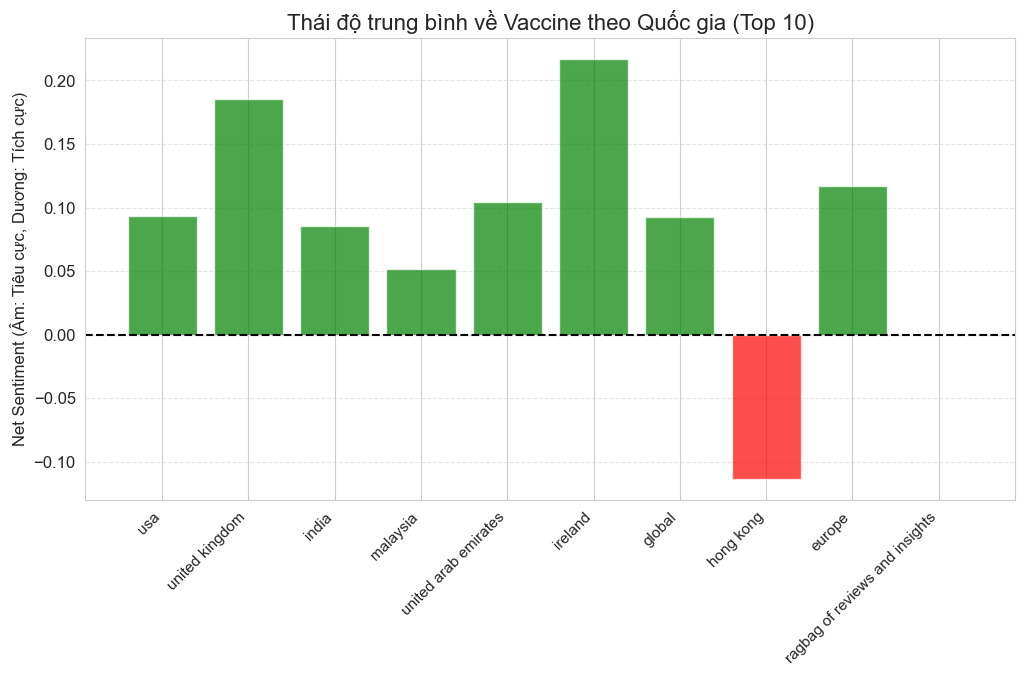

In [38]:
# Giả sử bạn đã map được cột 'country' (nếu chưa có thì bỏ qua bước này)
if 'user_location' in new_data.dtype.names:
    countries = new_data['user_location']
    sentiments = new_data['sentiment_label']
    
    # Lọc các nước phổ biến (Top 10)
    top_countries = [x[0] for x in Counter(countries).most_common(10) if x[0] != 'Unknown']
    
    avg_sent_by_country = []
    for c in top_countries:
        # Lọc theo nước
        if isinstance(countries[0], bytes):
            mask = countries == c.encode('utf-8') if isinstance(c, str) else countries == c
        else:
            mask = countries == c
            
        # Tính điểm trung bình (0: Neg -> 2: Pos)
        # Trừ 1 để về thang -1 đến 1 cho dễ nhìn
        avg = np.mean(sentiments[mask]) - 1 
        avg_sent_by_country.append(avg)
        
    # Vẽ biểu đồ
    plt.figure(figsize=(12, 6))
    colors = ['red' if x < 0 else 'green' for x in avg_sent_by_country]
    plt.bar(top_countries, avg_sent_by_country, color=colors, alpha=0.7)
    plt.axhline(0, color='black', linestyle='--')
    plt.title('Thái độ trung bình về Vaccine theo Quốc gia (Top 10)', fontsize=16)
    plt.ylabel('Net Sentiment (Âm: Tiêu cực, Dương: Tích cực)')

    plt.xticks(rotation=45, ha='right', fontsize=11) 
    
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()
else:
    print("Không tìm thấy cột 'country'. Bỏ qua phân tích địa lý.")

---
## **Tổng kết**
- Hầu hết mọi người có thái độ trung lập đối với các thông tin về vaccine, đồng thời có phần tích cực, ủng hộ đến với loại vaccine này
- các bài viết có thái độ tiêu cực thì mang xu hướng về tình hình chung của thé giới, những lo ngại về vaccine, ... (nhưng chiếm phần nhỏ)